# DATA SOURCE

nfl_historical_data.csv

In [1]:
import pandas as pd
data = pd.read_csv('nfl_historical_data.csv')
cols = [col for col in data.columns if col.startswith('prev_') or col=='resigned']
data = data[cols]

# Pipline

## Preprocessing

In [2]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Data_Processor:
    def __init__(self, dataframe, target):
        """
        Initialize the NFLDataProcessor with a dataframe.
        
        Parameters:
        -----------
        dataframe : pandas.DataFrame
        """
        self.data = dataframe
        self.target = target
        self.features = [col for col in self.data.columns if col != self.target]
    
    
    def analyze_null_values(self, silent=True):
        """
        Prints out how many null values there are per feature and what percent of rows have a null feature.
        
        Returns:
        --------
        self : Data_Pipline
            Returns self for method chaining
        """
        # drop null values from the target
        self.data = self.data[self.data[self.target].notna()]
        
        # Calculate null values per feature
        null_counts = self.data.isnull().sum()
        
        # Calculate percentage of rows with null values per feature
        null_percentage = (null_counts / len(self.data)) * 100
        
        # Combine the information
        null_info = pd.DataFrame({
            'Null Count': null_counts,
            'Null Percentage': null_percentage
        })
        
        # Print the results
        if not silent: print("Null Values Analysis:")
        # Filter for features with null values and sort in descending order
        null_features = null_info[null_info['Null Count'] > 0].sort_values('Null Count', ascending=False)
        
        if not silent:
            if null_features.empty:
                print("No columns have null values.")
            else:
                print(null_features)
        
        # Calculate overall percentage of rows with at least one null value
        rows_with_nulls = self.data.isnull().any(axis=1).sum()
        percent_rows_with_nulls = (rows_with_nulls / len(self.data)) * 100
        if not silent: print(f"\nTotal rows with at least one null value: {rows_with_nulls} ({percent_rows_with_nulls:.2f}%)")

        # Print rows with null values if any exist
        if rows_with_nulls > 0:
            if not silent: print("\nRows with null values:")
            rows_with_null_values = self.data[self.data.isnull().any(axis=1)]
            if not silent: display(rows_with_null_values)
        else:
            if not silent: print("\nNo rows contain null values.")

        self.null_count = null_counts.sum()
        
        return self
    
    def test_normality(self, columns=None, output=False, plot=False):
        """
        Performs normality tests on all numeric features.
        - Uses Shapiro-Wilk test if there are fewer than 5000 rows
        - Uses D'Agostino-Pearson test otherwise
        Also calculates skewness and kurtosis for each feature.
        
        Returns:
        --------
        self : Data_Pipline
            Returns self for method chaining
        """

        
        # Get only numeric columns (excluding the target)
        if columns is not None:
            numeric_cols = columns
        else:
            numeric_cols = self.data.select_dtypes(include=['number']).columns
            numeric_cols = [col for col in numeric_cols if col != self.target]
        
        # Initialize lists to store results
        features = []
        test_results = []
        skewness = []
        kurtosis_values = []
        test_name = []
        p_values = []
        
        # Determine which test to use based on sample size
        if len(self.data) < 5000:
            test_type = "Shapiro-Wilk"
            if output: print(f"Testing Normality with Shapiro-Wilk test (n={len(self.data)} < 5000)")
        else:
            test_type = "D'Agostino-Pearson"
            if output: print(f"Testing Normality with D'Agostino-Pearson test (n={len(self.data)} >= 5000)")
        
        # Perform tests for each numeric feature
        for col in numeric_cols:
            # Skip columns with all NaN values
            if self.data[col].isna().all():
                continue
                
            # Get data without NaN values
            data = self.data[col].dropna()
            
            # Calculate skewness and kurtosis
            skew = stats.skew(data)
            kurt = stats.kurtosis(data)
            
            # Perform normality test
            if test_type == "Shapiro-Wilk":
                # Shapiro-Wilk test
                stat, p = stats.shapiro(data)
            else:
                # D'Agostino-Pearson test
                stat, p = stats.normaltest(data)
            
            # Store results
            features.append(col)
            test_results.append("Normal" if p > 0.05 else "Not Normal")
            skewness.append(skew)
            kurtosis_values.append(kurt)
            test_name.append(test_type)
            p_values.append(p)
        
        # Create DataFrame with results
        normality_df = pd.DataFrame({
            'Feature': features,
            'Test': test_name,
            'Result': test_results,
            'p-value': p_values,
            'Skewness': skewness,
            'Kurtosis': kurtosis_values
        })
        
        # Display results
        

        
        # Check if self.normality already exists, if so, add new results as columns
        if hasattr(self, 'normality') and not self.normality.empty:
            # Filter for non-normal features
            non_normal_df = normality_df[normality_df['Result']=='Not Normal'].copy()
            
            # Add new results as columns to existing DataFrame
            for _, row in non_normal_df.iterrows():
                feature = row['Feature']
                if feature in self.normality['Feature'].values:
                    idx = self.normality[self.normality['Feature'] == feature].index
                    # Store previous values in new columns
                    self.normality.loc[idx, 'new_p-value'] = self.normality.loc[idx, 'p-value']
                    self.normality.loc[idx, 'new_Skewness'] = self.normality.loc[idx, 'Skewness']
                    self.normality.loc[idx, 'new_Kurtosis'] = self.normality.loc[idx, 'Kurtosis']
                    self.normality.loc[idx, 'new_Test'] = self.normality.loc[idx, 'Test']
                    self.normality.loc[idx, 'new_Result'] = self.normality.loc[idx, 'Result']
                    
                    # Update with new values
                    self.normality.loc[idx, 'p-value'] = row['p-value']
                    self.normality.loc[idx, 'Skewness'] = row['Skewness']
                    self.normality.loc[idx, 'Kurtosis'] = row['Kurtosis']
                    self.normality.loc[idx, 'Test'] = row['Test']
                    self.normality.loc[idx, 'Result'] = row['Result']
                else:
                    # Add new row for features not previously in self.normality
                    self.normality = pd.concat([self.normality, pd.DataFrame([row])], ignore_index=True)
        else:
            # If self.normality doesn't exist, create it
            self.normality = normality_df[normality_df['Result']=='Not Normal'].copy()

        if plot:
            # Filter for features that are still not normal
            if 'new_Result' in self.normality.columns:
                not_normal_features = self.normality[self.normality['new_Result'] == 'Not Normal']
            else:
                not_normal_features = self.normality[self.normality['Result'] == 'Not Normal']
            
            n_features = len(not_normal_features)
            
            if n_features > 0:
                # Calculate number of rows and columns for subplots
                n_cols = min(3, n_features)
                n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
                
                # Create subplots
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
                axes = axes.flatten() if n_features > 1 else [axes]
                
                # Plot each non-normal feature in its own subplot
                for i, (_, row) in enumerate(not_normal_features.iterrows()):
                    feature = row['Feature']
                    sns.histplot(self.data[feature].dropna(), bins=30, kde=True, ax=axes[i])
                    axes[i].set_title(f'{feature}')
                    axes[i].set_xlabel('Value')
                    axes[i].set_ylabel('Frequency')
                
                # Hide any unused subplots
                for j in range(i+1, len(axes)):
                    axes[j].set_visible(False)
                    
                plt.tight_layout()
                plt.show()
            else:
                print("No non-normal features to plot.")

        if output:
            print("\nNormality Test Results:")
            if 'new_Result' in self.normality.columns:
                display(self.normality[self.normality['new_Result']=='Not Normal'])
            else:
                display(self.normality[self.normality['Result']=='Not Normal'])

        if 'new_Result' in self.normality.columns:
            self.non_normal_features = self.normality[self.normality['new_Result']=='Not Normal']['Feature'].to_list()
        else:
            self.non_normal_features = self.normality[self.normality['Result']=='Not Normal']['Feature'].to_list()
        
        self.non_normal_count = len(self.normality[self.normality['Result']=='Not Normal'])
        

        return self
    
    def normalitiy_transform(self, method='auto', output=False):
        """
        Apply appropriate transformations to normalize features identified as non-normal.
        
        Parameters:
        -----------
        method : str, default='auto'
            Method to determine transformation. Options: 'auto', 'log', 'sqrt', 'box-cox', 'yeo-johnson'
            'auto' will select the best transformation based on skewness and kurtosis
        output : bool, default=True
            If True, display before and after normality test results
            
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        if not hasattr(self, 'normality') or self.normality.empty:
            print("No non-normal features identified. Run check_normality() first.")
            return self
            
        # Track transformations applied
        transformations = {}
        
        # Process each non-normal feature
        for _, row in self.normality.iterrows():
            feature = row['Feature']
            skewness = row['Skewness']
            
            # Skip if feature has NaN values only
            if self.data[feature].isna().all():
                continue
                
            # Get data without NaN values
            data = self.data[feature].dropna()
            
            # Choose transformation method
            if method == 'auto':
                # Select transformation based on skewness
                if abs(skewness) > 1:
                    if skewness > 0:
                        transform_method = 'log'
                    else:
                        transform_method = 'sqrt'
                else:
                    transform_method = 'box-cox' if all(data > 0) else 'yeo-johnson'
            else:
                transform_method = method
                
            # Apply transformation
            try:
                if transform_method == 'log':
                    # Handle negative values if present
                    if data.min() <= 0:
                        min_val = data.min()
                        shift = abs(min_val) + 1 if min_val <= 0 else 0
                        self.data[feature] = np.log(self.data[feature] + shift)
                        transformations[feature] = f"log(x + {shift})"
                    else:
                        self.data[feature] = np.log(self.data[feature])
                        transformations[feature] = "log(x)"
                        
                elif transform_method == 'sqrt':
                    # Handle negative values if present
                    if data.min() < 0:
                        min_val = data.min()
                        shift = abs(min_val) + 1
                        self.data[feature] = np.sqrt(self.data[feature] + shift)
                        transformations[feature] = f"sqrt(x + {shift})"
                    else:
                        self.data[feature] = np.sqrt(self.data[feature])
                        transformations[feature] = "sqrt(x)"
                        
                elif transform_method == 'box-cox':
                    # Box-Cox requires all positive values
                    if data.min() <= 0:
                        min_val = data.min()
                        shift = abs(min_val) + 1
                        transformed, lambda_val = stats.boxcox(self.data[feature] + shift)
                        self.data[feature] = transformed
                        transformations[feature] = f"box-cox(x + {shift}, λ={lambda_val:.4f})"
                    else:
                        transformed, lambda_val = stats.boxcox(data)
                        # Create a temporary series with the right index
                        temp_series = pd.Series(index=self.data.index, dtype='float64')
                        # Use .loc to properly set values and avoid SettingWithCopyWarning
                        temp_series.loc[data.index] = transformed
                        self.data[feature] = temp_series
                        transformations[feature] = f"box-cox(x, λ={lambda_val:.4f})"
                        
                elif transform_method == 'yeo-johnson':
                    # Yeo-Johnson works with negative values
                    transformed, lambda_val = stats.yeojohnson(data)
                    # Create a temporary series with the right index
                    temp_series = pd.Series(index=self.data.index, dtype='float64')
                    # Use .loc to properly set values and avoid SettingWithCopyWarning
                    temp_series.loc[data.index] = transformed
                    self.data[feature] = temp_series
                    transformations[feature] = f"yeo-johnson(x, λ={lambda_val:.4f})"
                    
            except Exception as e:
                print(f"Error transforming {feature}: {str(e)}")
                continue
        
        if output and transformations:            
            # Add transformation information to self.normality
            for feature, transform in transformations.items():
                # Check if the feature already exists in normality dataframe
                if feature in self.normality['Feature'].values:
                    # Update the existing row with transformation info
                    idx = self.normality[self.normality['Feature'] == feature].index
                    self.normality.loc[idx, 'transformation'] = transform
                else:
                    # Create a new row for the normalized feature
                    new_row = pd.DataFrame({
                        'Feature': [feature],
                        'transformation': [transform]
                    })
                    self.normality = pd.concat([self.normality, new_row], ignore_index=True)
            display(self.normality)
            
        return self
    
    def handle_outliers(self, method='cap', threshold=2, drop=False, columns=None, output=False):
        """
        Handle outliers in numeric columns.
        
        Parameters:
        -----------
        method : str, default='cap'
            Method to handle outliers. Options: 'cap', 'iqr'
        threshold : float, default=2
            Number of standard deviations to use as threshold when method='cap'
            or IQR multiplier when method='iqr'
        drop : bool, default=False
            If True, drop outliers instead of capping them
        columns : list, default=None
            List of columns to check for outliers. If None, all numeric columns are used.
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Get numeric columns if not specified
        if columns is None:
            numeric_cols = self.data.select_dtypes(include=np.number).columns.tolist()
        else:
            numeric_cols = [col for col in columns if col in self.data.columns and np.issubdtype(self.data[col].dtype, np.number)]
        
        # Track outliers found
        outlier_counts = {}
        
        for col in numeric_cols:
            # Skip columns with all NaN values
            if self.data[col].isna().all():
                continue
            
            # Get data without NaN values
            data = self.data[col].dropna()
            
            if method == 'cap':
                # Calculate mean and standard deviation
                mean = data.mean()
                std = data.std()
                
                # Define lower and upper bounds
                lower_bound = mean - threshold * std
                upper_bound = mean + threshold * std
                
                # Identify outliers
                outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)].index
                
            elif method == 'iqr':
                # Calculate Q1, Q3 and IQR
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                
                # Define lower and upper bounds
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                
                # Identify outliers
                outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)].index
            
            else:
                raise ValueError("Method must be 'cap' or 'iqr'")
            
            # Store count of outliers
            outlier_counts[col] = len(outliers)
            
            if len(outliers) > 0:
                if drop:
                    # Drop outliers
                    self.data = self.data.drop(outliers)
                else:
                    # Cap outliers
                    self.data.loc[self.data[col] < lower_bound, col] = lower_bound
                    self.data.loc[self.data[col] > upper_bound, col] = upper_bound
        
        # Display summary of outliers handled
        print(f"\nOutliers handled using {method} method with threshold={threshold}")
        
        
        outlier_df = pd.DataFrame({
            'Feature': list(outlier_counts.keys()),
            'Outliers Count': list(outlier_counts.values())
        })
        
        # Sort by count in descending order
        outlier_df = outlier_df.sort_values('Outliers Count', ascending=False)
        
        # Display only features with outliers
        if output:
            display(outlier_df[outlier_df['Outliers Count'] > 0])
        
        print(f"{outlier_df['Outliers Count'].sum()} Outliers were handled")
        print(f"greatest affected feature: {outlier_df.iloc[0,0]}, {round(outlier_df.iloc[0,1]/len(self.data)*100)}% affected\n")

        return self

    def drop_features(self, features_to_drop, output=False):
        """
        Drop specified features from the dataset and update self.features list
        
        Parameters:
        -----------
        features_to_drop : list
            List of feature names to drop from the dataset
        output : bool, default=True
            Whether to display information about dropped features
            
        Returns:
        --------
        self : object
            Returns the instance itself
        """
        # Check if features_to_drop is a list
        if not isinstance(features_to_drop, list):
            raise TypeError("features_to_drop must be a list of feature names")
        
        # Check if all features in features_to_drop exist in the dataset
        non_existent_features = [f for f in features_to_drop if f not in self.data.columns]
        if non_existent_features:
            print(f"Warning: The following features do not exist in the dataset: {non_existent_features}")
            # Filter out non-existent features
            features_to_drop = [f for f in features_to_drop if f in self.data.columns]
        
        # Drop features from the dataset
        self.data = self.data.drop(columns=features_to_drop)
        
        # Update self.features list
        self.features = [f for f in self.features if f not in features_to_drop]
        
        if output:
            print(f"Dropped {len(features_to_drop)} features:")
            for feature in features_to_drop:
                print(f"- {feature}")
            print(f"Remaining features: {len(self.features)}")
        
        return self
    
    def normalize_features(self, method='z-score', output=False): # dont use this here, allows leakage in model building
        """
        Normalize numerical features in the dataset.
        
        Parameters:
        -----------
        method : str, default='z-score'
            Normalization method to use. Options are:
            - 'z-score': Standardization (mean=0, std=1)
            - 'min-max': Min-Max scaling to range [0, 1]
        output : bool, default=False
            Whether to display information about the normalization process
            
        Returns:
        --------
        self : object
            Returns the instance itself
        """
        # Validate method parameter
        valid_methods = ['z-score', 'min-max']
        if method not in valid_methods:
            raise ValueError(f"method must be one of {valid_methods}")
        
        # Get numerical features (excluding the target variable)
        numerical_features = [f for f in self.features if f != self.target and 
                             pd.api.types.is_numeric_dtype(self.data[f])]
        
        if output:
            print(f"Normalizing {len(numerical_features)} numerical features using {method} method")
        
        # Apply normalization based on selected method
        if method == 'z-score':
            # Z-score standardization: (x - mean) / std
            for feature in numerical_features:
                mean = self.data[feature].mean()
                std = self.data[feature].std()
                if std > 0:  # Avoid division by zero
                    self.data[feature] = (self.data[feature] - mean) / std
                else:
                    if output:
                        print(f"Warning: Feature '{feature}' has zero standard deviation. Skipping normalization.")
        
        elif method == 'min-max':
            # Min-Max scaling: (x - min) / (max - min)
            for feature in numerical_features:
                min_val = self.data[feature].min()
                max_val = self.data[feature].max()
                if max_val > min_val:  # Avoid division by zero
                    self.data[feature] = (self.data[feature] - min_val) / (max_val - min_val)
                else:
                    if output:
                        print(f"Warning: Feature '{feature}' has equal min and max values. Skipping normalization.")
        
        if output:
            print("Normalization complete.")
        
        return self

### Test


Outliers handled using cap method with threshold=2
112 Outliers were handled
greatest affected feature: prev_drive_inside20_offense, 8% affected

Testing Normality with Shapiro-Wilk test (n=48 < 5000)


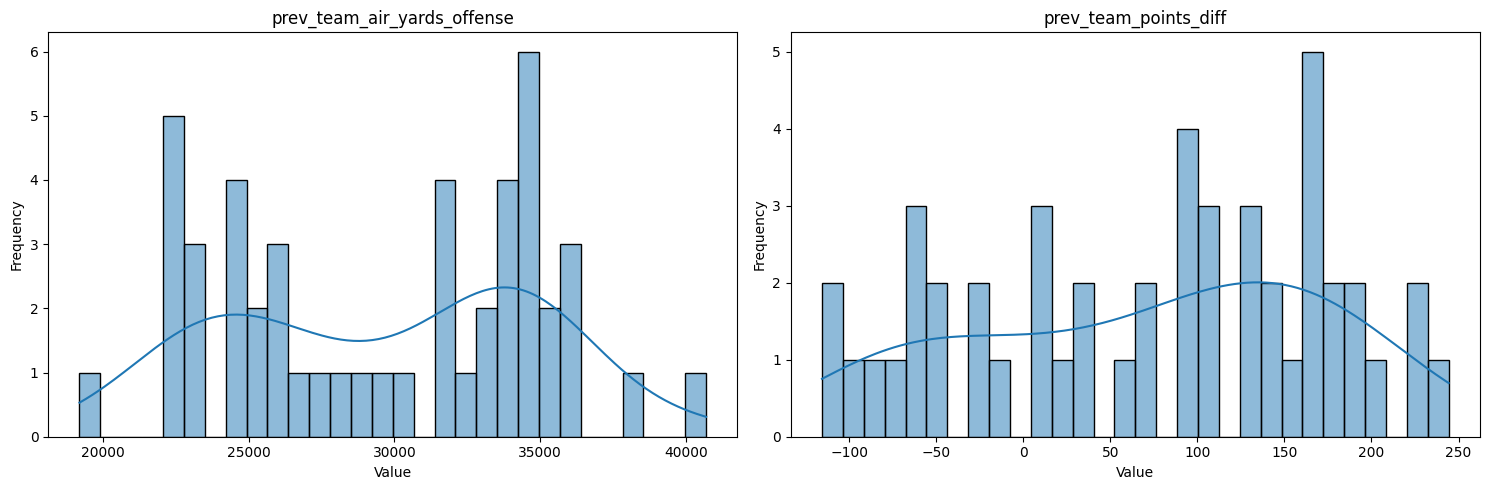


Normality Test Results:


,Feature,Test,Result,p-value,Skewness,Kurtosis,new_p-value,new_Skewness,new_Kurtosis,new_Test,new_Result
45,prev_team_air_yards_offense,Shapiro-Wilk,Not Normal,0.014249,-0.074273,-1.179257,0.013351,-0.117019,-1.184284,Shapiro-Wilk,Not Normal
67,prev_team_points_diff,Shapiro-Wilk,Not Normal,0.043062,-0.269488,-1.100713,0.020100,-0.457610,-0.925086,Shapiro-Wilk,Not Normal


Dropped 2 features:
- prev_team_air_yards_offense
- prev_team_points_diff
Remaining features: 68


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


test_process = Data_Processor(data, 'resigned')
## Stop to figure out what to do with nulls
test_process.analyze_null_values().handle_outliers(output=False).test_normality().normalitiy_transform().test_normality(output=True, plot=True)
## Stop to figure out what to do with remaining non-normal features
test_process.drop_features(['prev_team_air_yards_offense', 'prev_team_points_diff'], output=True)

## Feature Selection

In [4]:
class Data_features:
    def __init__(self, dataframe, target):
        from pandas.api.types import is_numeric_dtype

        self.data = dataframe.reset_index(drop=True)
        self.target = target
        self.features = [col for col in self.data.columns if col != self.target]
        self.numeric_features = self.data[self.features].select_dtypes(include='number').columns.tolist()
        self.categorical_features = self.data[self.features].select_dtypes(exclude='number').columns.tolist()
        self.binary_features = [col for col in self.features if self.data[col].nunique() == 2]
        self.multiclass_features = [col for col in self.categorical_features if col not in self.binary_features]
        self.target_correlations = None

        # Determine target type
        self.target_type = 'numeric' if is_numeric_dtype(self.data[self.target]) else 'categorical'
        if self.data[self.target].nunique() <= 5:
            self.target_type = 'categorical'
        if self.data[self.target].nunique() == 2:
            self.target_type = 'binary'

        # execute default functions to create additional attributes
        self._poly_feature_selection() # returns self.poly_features (used to identify polynomial and interaction for use in feature selection)
        self._bin() # returns self.binned_data
        self._svd() # returns self.svd_data, self.svd_features, self.svd_ftr_importance
        self._dt_feature_selection() # returns self.dt_feature_importance
        
        # use all collected information to find most important features
        self._target_correlation() # returns self.target_correlations



    def _bin(self, bins = 4):
        df = self.data.copy()
        binned_df = self.data.copy()
        
        for col in df[self.features].select_dtypes(include='number').columns:
            # Bin into quartiles and label them 1–4
            binned_df[col] = pd.qcut(df[col], q=4, labels=[1, 2, 3, 4])
        
        self.binned_data = binned_df
    
    def _target_correlation(self, top_n = 15, pval_zero = False, svd = False):
        from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, mutual_info_regression
        from scipy.stats import pearsonr
        import dcor

        # option to use alternate features, like SVD
        features = self.features
        feature_data = self.data
        target_data = self.data[self.target]
        
        if svd:
            features = self.svd_features
            feature_data = self.svd_data
            target_data = self.data[self.target]


        def mi_clf_discrete_ft(col):
            mi = mutual_info_classif(feature_data[col].to_numpy().reshape(-1, 1), target_data.astype('category'), discrete_features=True)
            return mi
        def mi_clf_continuous_ft(col):
            mi = mutual_info_classif(feature_data[col].to_numpy().reshape(-1, 1), target_data.astype('category'), discrete_features=False)
            return mi
        def mi_reg_discrete_ft(col):
            mi = mutual_info_regression(feature_data[col].to_numpy().reshape(-1, 1), target_data, discrete_features=True)
            return mi
        def mi_reg_continuous_ft(col):
            mi = mutual_info_regression(feature_data[col].to_numpy().reshape(-1, 1), target_data, discrete_features=False)
            return mi
        def chi_square(col):
            f, p = chi2(feature_data[col].to_numpy().reshape(-1, 1), target_data.astype('category'))
            # return 1-p value for compound calculation, return 0 if option selected and p > 0.05
            if pval_zero:
                return [1-p[0] if p[0] < 0.05 else 0]
            else:
                return [1-p[0]]
        def anova(col): 
            # set the categorical value to the target
            target = target_data
            feature = feature_data[col].to_numpy().reshape(-1, 1)
            if self.target_type == 'numeric':
                target = feature_data[col].to_numpy().reshape(-1, 1)
                feature = target_data
            f, p = f_classif(feature, target)
            # return 1-p value for compound calculation, return 0 if option selected and p > 0.05
            # if pval_zero:
            #     return [1-p[0] if p[0] < 0.05 else 0]
            # else:
            #     return [1-p[0]]
            return f
        def dcorr(col):
            dcor_val = dcor.distance_correlation(feature_data[col], target_data)
            return dcor_val
        def kulc(col): # removed from consideration because of less widspread use and overlap with usecase of lift (binary to binary)
            n = len(feature_data)
            target = target_data
            support_target = target_data.sum() / n
            support_item = feature_data[col].sum() / n
            support_both = ((feature_data[col] == 1) & (self.target == 1)).sum() / n
            if support_item > 0 and support_target > 0:
                kulc = 0.5 * ((support_both / support_item) + (support_both / support_target))
            return kulc
        def lift(col):
            n = len(feature_data)
            p_y = target_data.sum() / n
            p_x = feature_data[col].sum() / n
            p_xy = ((feature_data[col] == 1) & (target_data == 1)).sum() / n
            if p_x > 0 and p_y > 0:
                lift = p_xy / (p_x * p_y)
            return lift
        def corr(col):
            corr, _ = pearsonr(feature_data[col].to_numpy().reshape(-1, 1), target_data)
            return corr
        def test_list(col):
            from pandas.api.types import is_numeric_dtype
            feature_type = 'numeric'
            if col in self.binary_features: feature_type = 'binary'
            if col in self.multiclass_features: feature_type = 'categorical'

            possible_target_tests = {
                'binary' : {mi_clf_discrete_ft, mi_clf_continuous_ft, chi_square, lift},
                'categorical' : {mi_clf_discrete_ft, mi_clf_continuous_ft, chi_square},
                'numeric' : {mi_reg_discrete_ft, mi_reg_continuous_ft, dcorr, corr}
            }
            possible_feature_tests = {
                'binary' : {mi_clf_discrete_ft, mi_reg_discrete_ft, chi_square, lift},
                'categorical' : {mi_clf_discrete_ft, mi_reg_discrete_ft, chi_square},
                'numeric' : {mi_clf_continuous_ft, mi_reg_continuous_ft, dcorr, corr}
            }
            anova_test = {}
            if self.target_type == 'numeric' and feature_type in ['categorical', 'binary']: anova_test = {anova}
            if self.target_type in ['categorical', 'binary'] and feature_type == 'numeric': anova_test = {anova}

            tests = possible_target_tests[self.target_type].intersection(possible_feature_tests[feature_type])
            tests = tests.union(anova_test)

            return tests

        correlations = {}
        for col in features:
            correlations[col] = {}
            for test in test_list(col):
                correlations[col][test.__name__] = test(col)[0]
            if not svd:
                correlations[col]['svd_importance'] = self.svd_ftr_importance.loc[self.svd_ftr_importance['Feature'] == col, 'Importance'].values[0]
            correlations[col]['dt_importance'] = self.dt_feature_importance.loc[self.dt_feature_importance['Feature'] == col, 'Importance'].values[0]


        # turn dict into dataframe
        correlations = pd.DataFrame(correlations).T

        # normalize all columns to 0-1 scale
        for col in correlations.columns:
            correlations[col] = (correlations[col] - correlations[col].min()) / (correlations[col].max() - correlations[col].min())

        # calculate mean of all (non nan) corelation features
        correlations['compound_correlation'] = correlations.mean(axis=1, numeric_only=True)

        self.target_correlations = correlations.sort_values(by='compound_correlation', ascending=False)
        return self

    def plot_target_correlation(self, top_n = 10, pval_zero = True, svd = False):
        import matplotlib.pyplot as plt
        import numpy as np
        import textwrap

        plt.figure(figsize=(18, 5))
        
        # Get top N features
        plot_data = self.target_correlations.head(top_n)
        
        # Setup for bar chart
        wrap_lables = [textwrap.fill(label, width=16) for label in plot_data.index]
        wrap_lables = [label.replace(" ", "\nx\n") for label in wrap_lables]
        features = wrap_lables
        # features = plot_data.index
        correlation_types = [col for col in plot_data.columns if col != 'compound_correlation']
        
        # Calculate positions for grouped bars
        x = np.arange(len(features))
        width = 0.8 / len(correlation_types)  # Width of bars with spacing
        
        # Plot bars for each correlation type
        for i, column in enumerate(correlation_types):
            offset = (i - len(correlation_types)/2 + 0.5) * width
            plt.bar(x + offset, plot_data[column], width=width, label=column, alpha=0.5)
        
        # Plot compound correlation as a line
        plt.plot(x, plot_data['compound_correlation'], 'o-', linewidth=3, 
                 label='compound_correlation', markersize=8, color='black')
        
        plt.xticks(x, features, rotation=0)
        plt.xlabel('Features')
        plt.ylabel('Correlation Value')
        plt.title(f'Top {top_n} Features by Correlation with Target')
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        plt.show()

        return self
    
    def _svd(self):
        from sklearn.decomposition import TruncatedSVD

        svd = TruncatedSVD(n_components=len(self.features))
        svd.fit(self.data[self.features])
        cum_var = np.cumsum(svd.explained_variance_ratio_)
        k = np.argmax(cum_var >= 0.90) + 1
        # print(svd.singular_values_)

        svd = TruncatedSVD(n_components=k)
        svd.fit(self.data[self.features])
        self.svd_features = ['svd_' + str(k) for k in range(k)]
        self.svd_data = pd.DataFrame(svd.transform(self.data[self.features]), columns=self.svd_features)

        # sum absolute values of components for each feature
        self.svd_ftr_importance = pd.DataFrame({'Feature': self.features, 'Importance': np.abs(svd.components_).sum(axis=0)}).sort_values(by='Importance', ascending=False)

        return self

    def _dt_feature_selection(self):
        from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

        if self.target_type in ['categorical', 'binary']:
            dt = DecisionTreeClassifier(random_state=0)
            target = self.data[self.target].astype('category')
        else: 
            dt = DecisionTreeRegressor(random_state=0)
            target = self.data[self.target]

        dt.fit(self.data[self.features], target)

        self.dt_feature_importance = pd.DataFrame({'Feature': self.features, 'Importance': dt.feature_importances_}).sort_values(by='Importance', ascending=False)

        return self

    def _poly_feature_selection(self, feature_limit = 15):
        from sklearn.linear_model import Lasso, LogisticRegression
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.preprocessing import StandardScaler
        # create polynomials and interaction terms and scale data
        poly = PolynomialFeatures(degree=2, include_bias=True)
        scaler = StandardScaler()
        x_poly = poly.fit_transform(self.data[self.features])
        x = scaler.fit_transform(x_poly)
        

        # select appriate model for classification or regression
        if self.target_type in ['categorical', 'binary']:
            regularization = 1
            regularization_change = 0.2
            reg_param = 'C'
            model = LogisticRegression(random_state=0, penalty='l1', solver='liblinear', C=regularization)
            target = self.data[self.target].astype('category')
        else: 
            regularization = 0.1
            regularization_change = 5
            reg_param = 'alpha'
            model = Lasso(random_state=0, alpha=regularization)
            target = self.data[self.target]

        lr = model.fit(x, target)
        number_non_zero_coef = len([coef for coef in lr.coef_[0] if coef>0])

        while number_non_zero_coef > feature_limit:
            regularization = regularization * regularization_change
            model.set_params(**{reg_param: regularization})

            lr = model.fit(x, target)
            number_non_zero_coef = len([coef for coef in lr.coef_[0] if coef>0])
        
        poly_df = pd.DataFrame({'Feature': poly.get_feature_names_out(self.features), 'Importance': lr.coef_[0]})
        poly_df = poly_df[~poly_df['Feature'].isin(self.features)].sort_values(by='Importance', ascending=False)
        self.poly_features = poly_df[poly_df['Importance']>0]


        temp = pd.DataFrame(x_poly, columns=poly.get_feature_names_out(self.features))
        temp = temp[self.poly_features['Feature'].to_list()].fillna(0)

        # temp = self.data[temp.columns]
        self.data[temp.columns] = temp
        self.features.extend(temp.columns)

        return self

### Test

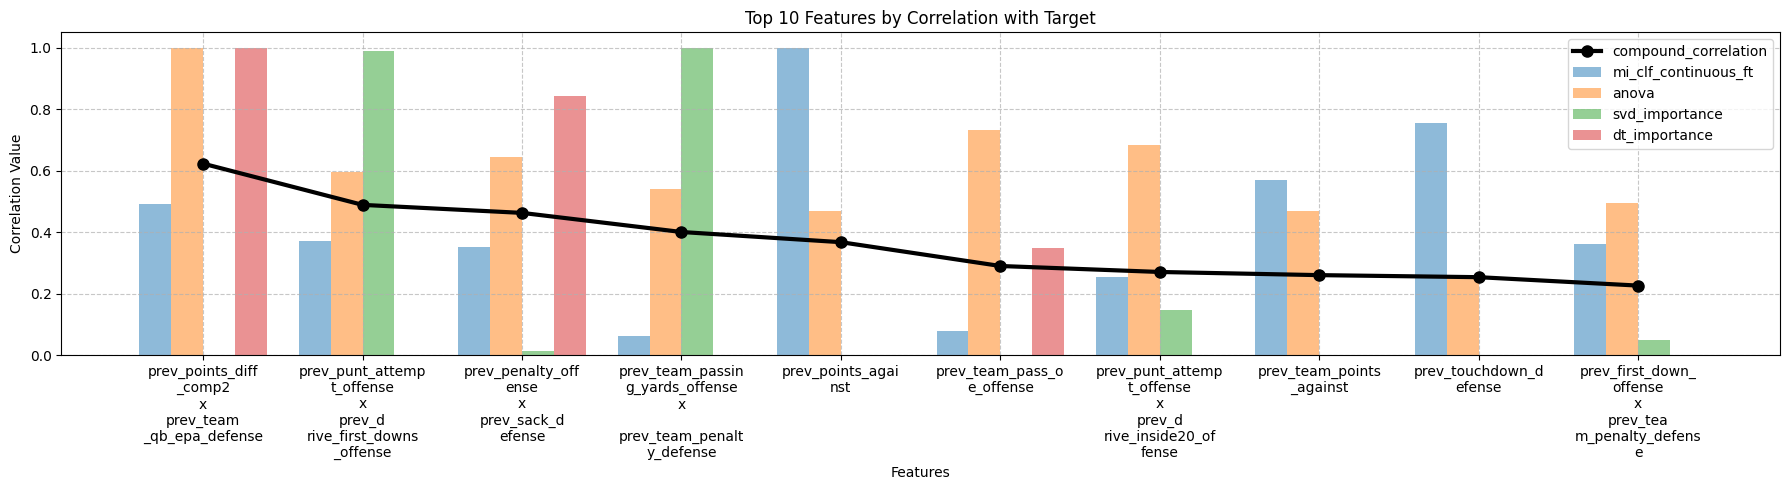

In [5]:
test = Data_features(test_process.data, test_process.target)
test.plot_target_correlation()

## Modeling

In [9]:
class Data_model:
    def __init__(self, dataframe, target, drop=True):
        import warnings
        warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

        # log original inputs
        self._original_data = dataframe
        self._original_target = target    

        data_processor = Data_Processor(dataframe, target)
        
        # first check for nulls
        if data_processor.analyze_null_values().null_count > 0:
            data_processor.analyze_null_values(silent=False)
            raise ValueError("nulls must be addressed")
        
        # handle outliers
        data_processor.handle_outliers(output=False)

        # test normality
        data_processor.test_normality().normalitiy_transform()
        initial_non_normal = len(data_processor.non_normal_features)
        data_processor.test_normality()
        post_non_normal = len(data_processor.non_normal_features)
        print(f"{initial_non_normal} non normal features identified\n{initial_non_normal - post_non_normal} features normalized, {post_non_normal} dropped \
              \n(to recover dropped features use initialize with drop=False) \
              \n(.see_non_normal to see distribution of dropped features)\n")
        if drop: data_processor.drop_features(data_processor.non_normal_features, output=True)

        # store data processer for later reference
        self.data_processed = data_processor


        # feature selection
        feature_selector = Data_features(data_processor.data, data_processor.target)
        feature_selector.plot_target_correlation()

        # store feature selector for later reference
        self.feature_model = feature_selector
        self.ordered_features = feature_selector.target_correlations.index.to_list()
        self.ordered_feature_correlations = feature_selector.target_correlations
    
    def see_non_noraml(self):
        # input from original data
        data_processor = Data_Processor(self._original_data, self._original_target)
        
        # handle outliers
        data_processor.handle_outliers(output=False)

        # test normality
        data_processor.test_normality().normalitiy_transform()
        data_processor.test_normality(output=True, plot=True)
        return self
    
    def see_full_feature_corr(self):
        import matplotlib.pyplot as plt
        import numpy as np
        import textwrap

        plt.figure(figsize=(18, 5))
        
        # Get top N features
        plot_data = self.ordered_feature_correlations
        
        # Setup for bar chart
        wrap_lables = [textwrap.fill(label, width=40) for label in plot_data.index]
        wrap_lables = [label.replace(" ", " x ") for label in wrap_lables]
        features = wrap_lables

        
        # Plot compound correlation as a line
        plt.plot(plot_data.index.to_list(), plot_data['compound_correlation'], 'o-', linewidth=3, 
                 label='compound_correlation', markersize=8, color='black')
        
        plt.xticks(plot_data.index.to_list(), features, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Correlation Value')
        plt.title(f'Features by Correlation with Target')
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        plt.show()

        return self
    


### Test

In [7]:
data = pd.read_csv('nfl_historical_data.csv')
data = data[data['side']=='def']
cols = [col for col in data.columns if col.startswith('prev_') or col=='resigned']
data = data[cols]


Outliers handled using cap method with threshold=2
58 Outliers were handled
greatest affected feature: prev_pass_epa_defense, 8% affected

1 non normal features identified
0 features normalized, 1 dropped               
(to recover dropped features use initialize with drop=False)               
(.see_non_normal to see distribution of dropped features)

Dropped 1 features:
- prev_team_air_yards_offense
Remaining features: 69


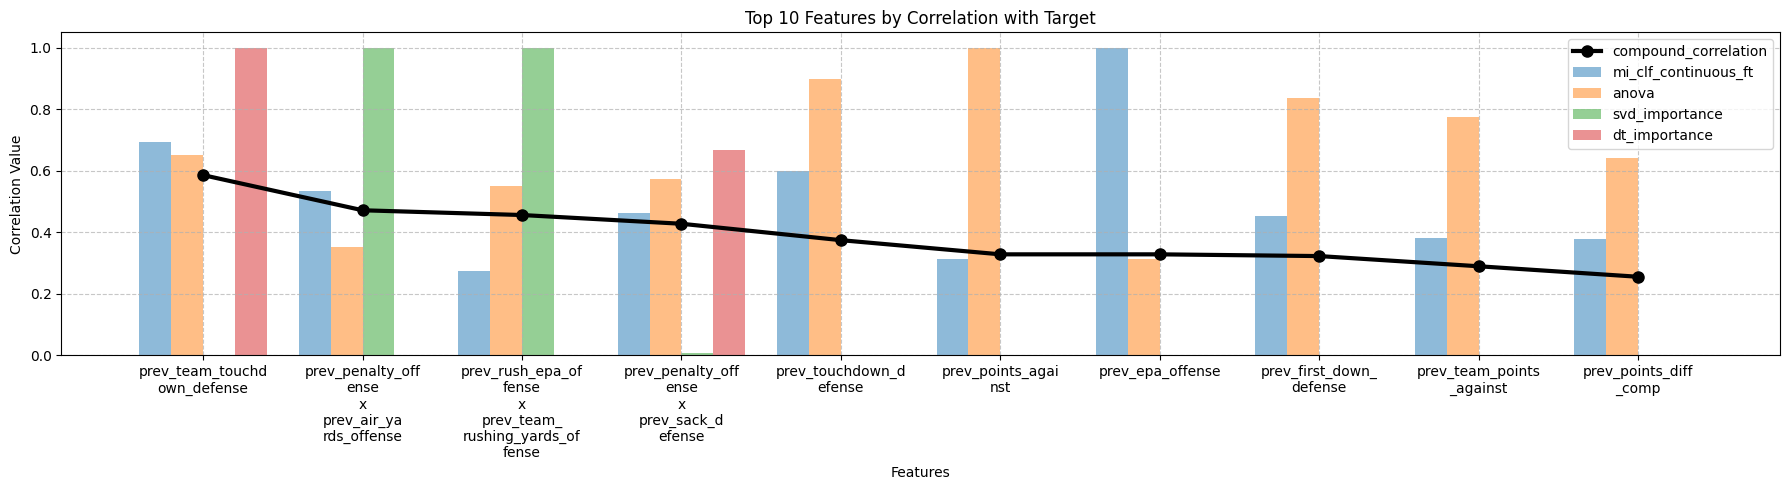

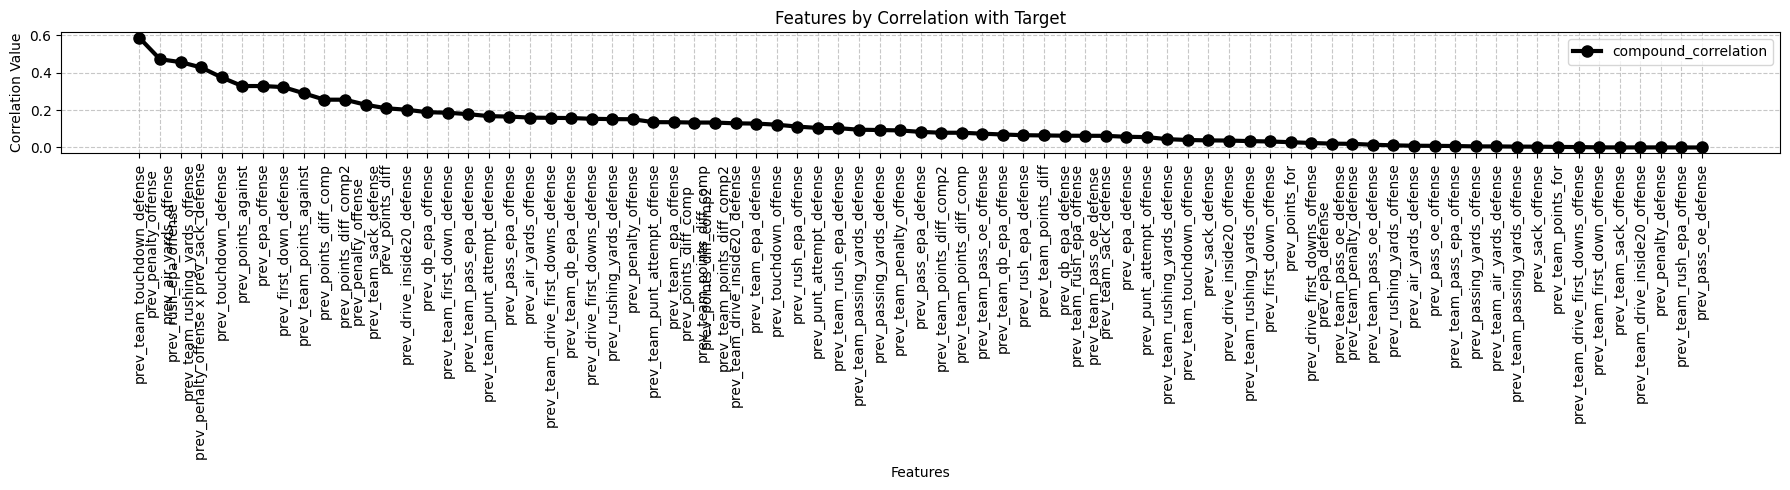

In [10]:
test = Data_model(data, 'resigned')
# test.see_non_noraml()
test.see_full_feature_corr()